# Base Models and Iteration

After combing through the feature relationship with price in EDA, I separated the numeric variables into groups ranked by the strength of their price relationship. A features I wanted to include immediately, B maybe later, and C not at all.

I dealt with Categorical varriables in a similar way, ranking them according to the utility I expected them to lend a model. I picked out those I wanted to engineer and test from the start, those I could engineer later on, and those I expected to be redundant or just noise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV

In [2]:
def rmse(model, X, y):
    model_preds = model.predict(X)
    mse = mean_squared_error(y, model_preds)
    return mse ** 0.5

In [3]:
df = pd.read_csv('../datasets/cleaned_housing_data.csv', keep_default_na=False, na_values=[''])
pd.options.display.max_columns = 99
df = df.drop(columns=['Unnamed: 0'])
df.head();

In [4]:
# The list below includes my rank 'A' numeric type features
features_A=[
    'Overall Qual',
    'Overall Cond',
    'Year Built',
    'Year Remod/Add',
    'Total Bsmt SF',
    '1st Flr SF',
    'Gr Liv Area',
    'TotRms AbvGrd',
    'Fireplaces',
    'Garage Yr Blt',
    'Garage Area'
]

In [5]:
# The list below includes my rank 'B' numeric type features
features_B=[
    'BsmtFin SF 1',
    '2nd Flr SF',
    'Bsmt Full Bath',
    'Full Bath',
    'Garage Cars',
    'Wood Deck SF',
    'Enclosed Porch',
    'Yr Sold',
    'Mas Vnr Area'
]

In [6]:
# The list below includes my rank 'C' numeric type features
features_C=[
    'Bsmt Half Bath',
    'Half Bath',
]

### Creating Base Model

In [7]:
#Define predictor and target variable(s):
X = df[features_A]
y = df['SalePrice']

In [8]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
#Instantiate, fit, score model:
lr = LinearRegression()
mod1 = lr.fit(X_train, y_train)
mod1.score(X_train, y_train), mod1.score(X_test, y_test)

(0.7856036530474535, 0.8294812034990572)

In [10]:
#Calculate RMSE: (train split)
rmse(mod1, X_train, y_train)

38186.77151578066

In [11]:
#Calculate RMSE: (test split)
rmse(mod1, X_test, y_test)

33562.338574476446

In [12]:
#Get predictions
preds = mod1.predict(X_test)

In [13]:
#Calculate residuals
resids = y_test - preds

In [14]:
#View coefficients
pd.DataFrame(mod1.coef_, index=X.columns)

,0
Overall Qual,21801.863282
Overall Cond,5139.605080
Year Built,424.420172
Year Remod/Add,174.103115
Total Bsmt SF,11.822055
1st Flr SF,13.607703
Gr Liv Area,33.240861
TotRms AbvGrd,2384.730936
Fireplaces,10581.381950
Garage Yr Blt,-123.567369


In [16]:
mod1_coefs = pd.DataFrame(mod1.coef_, index=X_train.columns, columns=['coef val'])
mod1_coefs.sort_values('coef val')

,coef val
Garage Yr Blt,-123.567369
Total Bsmt SF,11.822055
1st Flr SF,13.607703
Gr Liv Area,33.240861
Garage Area,72.222432
Year Remod/Add,174.103115
Year Built,424.420172
TotRms AbvGrd,2384.730936
Overall Cond,5139.605080
Fireplaces,10581.381950


<AxesSubplot:>

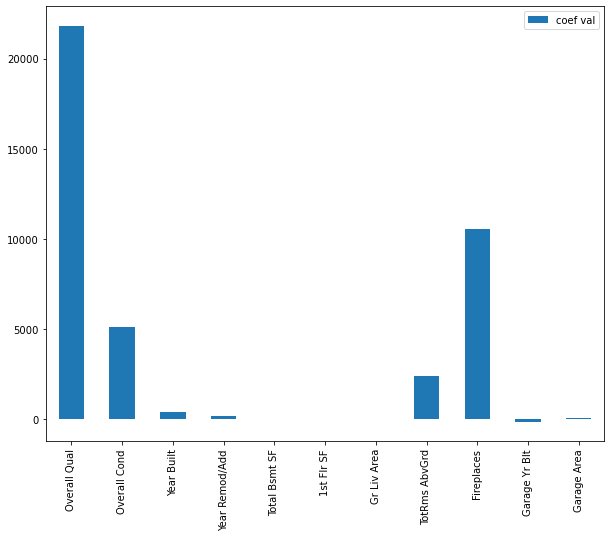

In [17]:
mod1_coefs.plot.bar(figsize=(10,8))

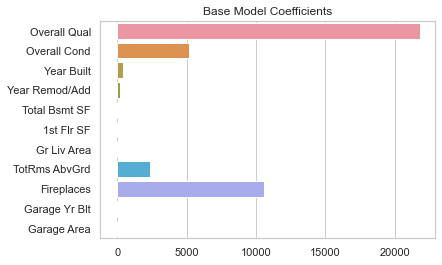

In [18]:
sns.figsize=(15, 30)
sns.set_theme(style='whitegrid')
sns.barplot(x=mod1.coef_, y=X_train.columns)
plt.title('Base Model Coefficients')
plt.savefig('../images/BaseCoef.png')

I want to introduce a pipe that scales features, adds polynomial interactions, and utilizes LassoCV:

In [19]:
pipe1 = Pipeline([
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('lr', LassoCV(verbose=True))
])

pipe1.fit(X_train, y_train)
pipe1.score(X_train, y_train), pipe1.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


(0.8305232954018911, 0.8260285145534947)

In [20]:
rmse(pipe1, X_train, y_train), rmse(pipe1, X_test, y_test)

(33951.522747032825, 33900.42326669801)

In [21]:
pipe1_coefs = pd.DataFrame(pipe1.named_steps['lr'].coef_, index = pipe1.named_steps['pf'].get_feature_names(X_train.columns), columns=['coef val'])
pipe1_coefs.sort_values('coef val', ascending=False)

/Users/kevingates/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,coef val
Overall Qual,30409.133169
Gr Liv Area,19057.079396
Total Bsmt SF,9080.186189
Garage Area,7608.269868
Overall Qual Garage Area,6601.911933
...,...
Overall Cond,0.000000
Year Built TotRms AbvGrd,0.000000
Year Built Fireplaces,0.000000
Garage Yr Blt Garage Area,0.000000


In [22]:
pipe1a = Pipeline([
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(interaction_only=False, include_bias=False)),
    ('lr', LassoCV(verbose=True))
])

pipe1a.fit(X_train, y_train)
pipe1a.score(X_train, y_train), pipe1a.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


(0.8527797610748361, 0.8463423346447588)

In [23]:
rmse(pipe1a, X_train, y_train), rmse(pipe1a, X_test, y_test)

(31643.754840950325, 31859.811355070462)

----

### Iterating from Base

In [24]:
#Define predictor and target variable(s):
X = df[features_A].drop(columns=['Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area', 'Year Remod/Add'])
y = df['SalePrice']

In [25]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
#Instantiate, fit, score model:
lr = LinearRegression()
mod2 = lr.fit(X_train, y_train)
mod2.score(X_train, y_train), mod2.score(X_test, y_test)

(0.7312793124148631, 0.7411859088937999)

In [27]:
#Calculate RMSE: 
rmse(mod2, X_train, y_train), rmse(mod2, X_test, y_test)

(42751.83921239244, 41348.527079849475)

In [28]:
#Define predictor and target variable(s):
X = df[features_A].drop(columns=['Year Built', 'Gr Liv Area', 'Garage Area', 'Year Remod/Add'])
y = df['SalePrice']

In [29]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
#Instantiate, fit, score model:
lr = LinearRegression()
mod3 = lr.fit(X_train, y_train)
mod3.score(X_train, y_train), mod3.score(X_test, y_test)

(0.7565873680828628, 0.7846453199891023)

In [31]:
#Calculate RMSE: 
rmse(mod3, X_train, y_train), rmse(mod3, X_test, y_test)

(40688.88679471767, 37717.529777543525)

Removing features from our A list tends to diminish model performance. Model scores up to this point indicate mild underfitting with the exception of pipe1 which indicates marginal overfitting. It's prrobably time to engineer some categorical features. But first I am going to try one more pipe with numerical features from feature list A, B, and C.

-----

In [32]:
features=features_A+features_B+features_C

In [33]:
#Define predictor and target variable(s):
X=df[features]
y=df['SalePrice']

In [34]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
#Instantiate, fit, score model:
lr = LinearRegression()
mod4 = lr.fit(X_train, y_train)
mod4.score(X_train, y_train), mod4.score(X_test, y_test)

(0.801660708745973, 0.8449802321609459)

In [36]:
#Calculate RMSE: 
rmse(mod4, X_train, y_train), rmse(mod4, X_test, y_test)

(36728.95994225373, 32000.710867031015)

In [37]:
pipe2 = Pipeline([
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('lr', LassoCV(verbose=True))
])

pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


(0.8182090377860828, 0.813488725139178)

In [38]:
rmse(pipe2, X_train, y_train), rmse(pipe2, X_test, y_test)

(35163.36237048502, 35100.93055533551)

In [39]:
pipe2_coefs = pd.DataFrame(pipe2.named_steps['lr'].coef_, index = pipe2.named_steps['pf'].get_feature_names(X_train.columns), columns=['coef val'])
pipe2_coefs.sort_values('coef val', ascending=False)

/Users/kevingates/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,coef val
Overall Qual,31811.511374
Gr Liv Area,17222.970173
Overall Qual Garage Cars,5088.468552
Garage Cars,4930.637462
Total Bsmt SF,4916.045996
...,...
Year Remod/Add Bsmt Half Bath,-0.000000
Year Remod/Add Half Bath,0.000000
Bsmt Half Bath Half Bath,-0.000000
Total Bsmt SF 1st Flr SF,-557.353745


In [40]:
pipe3 = Pipeline([
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(interaction_only=False, include_bias=False)),
    ('lr', LassoCV(verbose=True))
])

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train), pipe3.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
........................................................................................................................................................................................................................................................................................................................................................................................./Users/kevingates/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 698281208.6445312, tolerance: 661054201.2620329
  model = cd_fast.enet_coordinate_descent_gram(
./Users/kevingates/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

(0.9435758415979346, 0.9099394799225229)

In [41]:
rmse(pipe3, X_train, y_train), rmse(pipe3, X_test, y_test)

(19590.106503654035, 24391.208020912643)

This is my best model so far. From the scores it seems like it is overfit. I am going to see if removing some features with coef's zeroed by Lasso can make it even better.

In [42]:
pipe3_coefs = pd.DataFrame(pipe3.named_steps['lr'].coef_, index = pipe3.named_steps['pf'].get_feature_names(X_train.columns), columns=['coef val'])
pipe3_coefs.sort_values('coef val', ascending=False)

/Users/kevingates/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,coef val
Gr Liv Area,20668.272194
Overall Qual,19648.129545
Total Bsmt SF,11439.511930
Year Built,10450.218211
Year Remod/Add,9725.449019
...,...
Wood Deck SF Yr Sold,-3271.562964
1st Flr SF Gr Liv Area,-3973.213872
Total Bsmt SF 1st Flr SF,-4068.833344
Garage Area Half Bath,-5370.772868


In [43]:
pipe3_coefs[pipe3_coefs['coef val'] == 0].head()

,coef val
2nd Flr SF,0.0
Wood Deck SF,0.0
Bsmt Half Bath,-0.0
Overall Qual Overall Cond,-0.0
Overall Qual Year Built,-0.0


In [44]:
#Define predictor and target variable(s):
X=df[features].drop(columns=['Half Bath', 'Bsmt Half Bath', '2nd Flr SF', 'Wood Deck SF', 'Enclosed Porch', 'Yr Sold'])#, 'Mas Vnr Area', 'Full Bath'])
y=df['SalePrice']

In [45]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
pipe4 = Pipeline([
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(interaction_only=False, include_bias=False)),
    ('lr', LassoCV(verbose=True))
])

pipe4.fit(X_train, y_train)
pipe4.score(X_train, y_train), pipe4.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


(0.9330424669738732, 0.9188256225598422)

In [47]:
rmse(pipe4, X_train, y_train), rmse(pipe4, X_test, y_test)

(21340.46971084363, 23156.641282275814)

After trial and error with all the B and C list features, 'BsmtFin SF 1' has the greatest positive effect on model performance and should be kept in. None of the others seem to do very much.

Dropping Bsmt Full Bath decreased overfitting by <1% in train set but increased rmse by <1000. Garage Cars seems similarly limited in making a difference, increased train score <1%, decreased rmse <1000. Same with Full Bath.

-------

In [48]:
features = features_A + ['Mas Vnr Area', 'Full Bath', 'BsmtFin SF 1', 'Garage Cars']
print(features)

['Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Area', 'Mas Vnr Area', 'Full Bath', 'BsmtFin SF 1', 'Garage Cars']


In [49]:
#Define predictor and target variable(s):
X=df[features]
y=df['SalePrice']

In [50]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [51]:
pipe5 = Pipeline([
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(interaction_only=False, include_bias=False)),
    ('lr', LassoCV(verbose=True))
])

pipe5.fit(X_train, y_train)
pipe5.score(X_train, y_train), pipe5.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
/Users/kevingates/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.232e+09, tolerance: 8.121e+08
  model = cd_fast.enet_

(0.9313352958324199, 0.9188377542426759)

In [52]:
#Calculate rmse for train test splits
rmse(pipe5, X_train, y_train), rmse(pipe5, X_test, y_test)

(21610.809185260536, 23154.910813046903)

This model yields my best rmse score over the test split. I will proceed using this feature list and trry to improve further by feature engineering categorical variables.

### Generate Test Predictions for Kaggle

In [53]:
test = pd.read_csv('../datasets/test.csv', keep_default_na=False, na_values=[''])

In [54]:
test = test.fillna(0)

In [55]:
kaggle_preds = pipe5.predict(test[features])

In [56]:
test['SalePrice'] = kaggle_preds

In [57]:
test[['Id', 'SalePrice']].to_csv('GatesPrediction1.csv')

In [58]:
submission1 = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': kaggle_preds
})

In [59]:
submission1 = submission1.set_index('Id')

In [60]:
submission1

,SalePrice
Id,
2658,169584.943365
2718,120740.470598
2414,177467.739031
1989,114707.036183
625,178227.204529
...,...
1662,198913.239986
1234,228172.823792
1373,130821.568307


In [61]:
submission1.to_csv('../kaggle_subs/gates_pred1.csv')